In [1]:
import os, pickle, time, itertools, re, itertools

import helpers

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

# ignore warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, log_loss

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
import optuna
from lightgbm import early_stopping
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# fixate the random state for reproducability
RANDOM_STATE = 1337
seed(RANDOM_STATE)

## Data Prep

In [3]:
# read in complete labeled data set
df = pd.read_csv('../datasets/PowerShellCorpus.ast.csv')

# split into target variable and input features
paths = df.Path
y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

# split off 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# check the obf/non-obf labels for this training set
df.groupby('Label').count()['Path']

Label
0    7374
1    7328
Name: Path, dtype: int64

In [4]:
# from BorutaShap import BorutaShap
# Feature_Selector = BorutaShap(importance_measure='shap', classification=True)
# Feature_Selector = pickle.load(open("boruta-shap.bin", "rb"))
# Feature_Selector.accepted

# the above ^ results in the following "Accepted" features:
boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
print(f"Number of features selected from Boruta-Shap: {len(boruta_shap_accepted_features)}")
X_train_boruta_shap = X_train[boruta_shap_accepted_features]
X_test_boruta_shap = X_test[boruta_shap_accepted_features]

# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X_train_boruta_shap = X_train_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_boruta_shap = X_test_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Number of features selected from Boruta-Shap: 446


## Tree Model Evaluation

In [5]:
# tree algorithms are scaling invariant, so we don't need to use StandardScaler or MinMaxScaler
tree_pipelines = {
    'rf'  : RandomForestClassifier(n_jobs=2),
    'lgb' : LGBMClassifier(n_jobs=2),
    'xgb' : XGBClassifier(n_jobs=2)
}

rf_hyperparameters = { 
    'n_estimators': [50, 100, 300, 500, 1000, 1500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5, 7, 10, 15, 20]
}

lgb_hyperparameters = { 
    'n_estimators': [50, 100, 300, 500, 1000, 1500, 2000],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5, 7, 10, 15, 20]
}

xgb_hyperparameters = { 
    'n_estimators': [50, 100, 300, 500, 1000, 1500, 2000],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5, 7, 10, 15, 20]
}

tree_hyperparameters = {
    'rf'  : rf_hyperparameters,
    'lgb' : lgb_hyperparameters,
    'xgb' : xgb_hyperparameters
}

In [6]:
fit_tree_models = {}

for name, pipeline in tree_pipelines.items():

    print(f"Fitting: {name}")

    model = RandomizedSearchCV(pipeline, tree_hyperparameters[name], cv=5, n_jobs=5)
    
    fit_tree_models[name] = helpers.train_model(model, X_train_boruta_shap, y_train)

Fitting: rf
Fitting: lgb
Fitting: xgb


C:\Users\wschroeder\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
print(f"Model\tScore\t\t\tTraining Time")

for key,value in fit_tree_models.items():
    print(f"{key}\t{value[0].best_score_}\t{value[1]}")

Model	Score			Training Time
rf	0.9815490284511595	335.8934519290924
lgb	0.9859707248815377	126.5055410861969
xgb	0.9857154782865122	1315.8533301353455


In [8]:
pickle.dump(fit_tree_models, open("tree_models_boruta_shap.bin", "wb"))

## Winning Model Tuning

#### The top performing model was the LGBMClassifier - now we fine-tune a LGBMClassifier using Optuna

In [9]:
%%capture

import optuna.integration.lightgbm as lgb

# use a 30 min CV hyperparameter search as a starting point
timebudget = 30*60

dtrain1 = lgb.Dataset(X_train_boruta_shap.to_numpy(), label=y_train.to_numpy())

params1 = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

mystudy = optuna.create_study()  

tuner = lgb.LightGBMTunerCV(
    params1,
    dtrain1,
    folds=KFold(n_splits=5),
    callbacks=[early_stopping(100)],
    verbose_eval=False,
    time_budget=timebudget, 
    study = mystudy
)

tuner.run()

In [10]:
print("Best initial score :", tuner.best_score)
print("Best initial params:", tuner.best_params)

Best initial score : 0.05064373976270666
Best initial params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.9628361637058805e-07, 'lambda_l2': 0.00011865434347612717, 'num_leaves': 10, 'feature_fraction': 0.7520000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10}


In [11]:
%%capture

# now use those params as a base for a more complete hyperparameter search
#    adapted from https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py
#    ref on enqueue_trial - https://stackoverflow.com/questions/63875879/using-optuna-lightgbmtunercv-as-starting-point-for-further-search-with-optuna

import lightgbm as lgb

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_train_boruta_shap.to_numpy(), y_train.to_numpy(), test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 256),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy


# maximize accuracy this time
study = optuna.create_study(direction="maximize")

# use the first CV run as a starting point
study.enqueue_trial(tuner.best_params)

# # run for 1000 trials
# start_time = time.time()
# study.optimize(objective, n_trials=1000, n_jobs=4)
# print(f"Training Time: {time.time() - start_time}")

# run for 3 hours
study.optimize(objective, timeout=(3*60*60), n_jobs=4)

In [12]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 8360
Best trial:
  Value: 0.9911594695681741
  Params: 
    learning_rate: 0.08750550951125344
    num_leaves: 146
    lambda_l1: 7.136741225133361e-06
    lambda_l2: 1.6116201177123977e-05
    feature_fraction: 0.49054439641064074
    bagging_fraction: 0.9095072462806773
    bagging_freq: 13
    min_child_samples: 91


In [17]:
# retrain a tuned LGBM classifier with the best parameters
tuned_lgbm = LGBMClassifier(**trial.params)
start_time = time.time()
tuned_lgbm.fit(X_train_boruta_shap, y_train)
print(f"Fit in: {time.time() - start_time} seconds")

[LightGBM] [Warning] feature_fraction is set=0.49054439641064074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49054439641064074
[LightGBM] [Warning] lambda_l1 is set=7.136741225133361e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.136741225133361e-06
[LightGBM] [Warning] bagging_fraction is set=0.9095072462806773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9095072462806773
[LightGBM] [Warning] lambda_l2 is set=1.6116201177123977e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6116201177123977e-05
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
Fit in: 4.614326000213623 seconds


In [19]:
# save off the tuned model
pickle.dump(tuned_lgbm, open("../models/tuned_lgbm_boruta_shap.bin", "wb"))


===== Tuned LightGBM =====

   Accuracy (test) : 0.9867
   F1       (test) : 0.9867
   AUROC    (test) : 0.9980



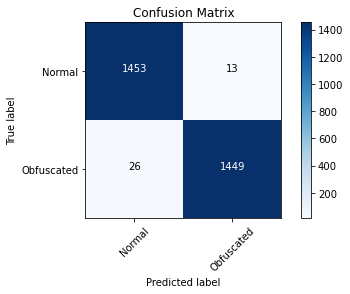

In [20]:
# evaluate our tuned model
helpers.evaluate_model("Tuned LightGBM", tuned_lgbm, X_test_boruta_shap, y_test)

In [16]:
# # Alternative objective function that uses 5-fold cross-validation:
# # from https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py
# def objective(trial):

#     param = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     }
    
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
#     cv_scores = np.empty(5)
    
#     for idx, (train_idx, test_idx) in enumerate(cv.split(X_train_boruta_shap, y_train)):
#         train_X, test_X = X_train_boruta_shap.iloc[train_idx], X_train_boruta_shap.iloc[test_idx]
#         train_y, test_y = y_train.iloc[train_idx], y_train.iloc[test_idx]

#         model = LGBMClassifier(**param)
#         model.fit(
#             train_X,
#             train_y
#         )
#         preds = model.predict(test_X)
#         pred_labels = np.rint(preds)
#         cv_scores[idx] = accuracy_score(test_y, pred_labels)

#     return np.mean(cv_scores)